In [1]:
# 04_log_prediction

In [2]:
# Force to reload extrernal modules every new cell execution
%reload_ext autoreload
%autoreload 2

In [3]:
### IMPORT ###
from pathlib import Path
import csv
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import re
from xgboost import XGBRegressor

In [4]:
### LOCAL IMPORT ###
from config import config_reader
from utilities import extract_files, convert_seconds_to_hours

In [5]:
### GLOBALS ###
yaml_config = config_reader.config_read_yaml("config.yml", "config")

dic_types = {"CaseID":object,  "TIMESTAMP":object, "ESI": int, "CASE_DURATION_sec": float, "REMAINING_TIME_sec":float} # <-- INPUT: columns types

encoding_dir = str(yaml_config["LOG_ENCODING_DIR"]) # <-- INPUT: the directory with files encoded for the ML models

# ML
ml_dir = str(yaml_config["ML_DIR"]) # <-- INPUT: the directoryin which to save ML results
label_column = "REMAINING_TIME_sec" # <-- INPUT: label for prediction
drop_column = ["CaseID", "TIMESTAMP"]  # <-- INPUT: columns to drop
cv_folds = 5 # <-- INPUT: number of folds for Cross Validation

# FUNCTIONS

In [6]:
def plot_custom_distribution(dataframe: pd.DataFrame, x_column: str, y_column: str) -> None:
    """
    This function takes a dataframe as input and displays a bar chart of the actual values
    for the specified columns.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing the columns to plot.
    x_column (str): The name of the column to use for the x-axis.
    y_column (str): The name of the column to use for the y-axis.
    """
    # Check that the specified columns exist in the dataframe
    if x_column not in dataframe.columns or y_column not in dataframe.columns:
        raise ValueError("The specified columns do not exist in the dataframe.")
    
    # Extract the data
    x_values = dataframe[x_column]
    y_values = dataframe[y_column]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(x_values, y_values, color='skyblue')
    plt.title(f'Distribution of {y_column} by {x_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [7]:
def plot_custom_distribution_with_colours(dataframe: pd.DataFrame, x_column: str, y_column: str, encoding_column: str) -> None:
    """
    This function takes a dataframe as input and displays a bar chart of the actual values
    for the specified columns, using distinct colours based on the encoding column.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing the columns to plot.
    x_column (str): The name of the column to use for the x-axis.
    y_column (str): The name of the column to use for the y-axis.
    encoding_column (str): The name of the column that determines the colour encoding.
    """
    # Check that the specified columns exist in the dataframe
    if x_column not in dataframe.columns or y_column not in dataframe.columns or encoding_column not in dataframe.columns:
        raise ValueError("The specified columns do not exist in the dataframe.")
    
    # Extract the data
    x_values = dataframe[x_column]
    y_values = dataframe[y_column]
    encoding_values = dataframe[encoding_column]

    # Create a colour map
    colours = encoding_values.map({'B': 'skyblue', 'F': 'lightgreen'})

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(x_values, y_values, color=colours)
    plt_title = f"Distribution of '{y_column}' by '{x_column}'"
    plt.title(plt_title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.legend(handles=[
        plt.Line2D([0], [0], color='skyblue', lw=4, label='B'),
        plt.Line2D([0], [0], color='lightgreen', lw=4, label='F')
    ], title=encoding_column)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [8]:
def plot_custom_distribution_side_by_side(dataframe: pd.DataFrame, x_column: str, y_column: str, encoding_column: str) -> None:
    """
    This function takes a dataframe as input and displays a side-by-side bar chart of the actual values
    for the specified columns, using distinct colours based on the encoding column.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing the columns to plot.
    x_column (str): The name of the column to use for the x-axis.
    y_column (str): The name of the column to use for the y-axis.
    encoding_column (str): The name of the column that determines the colour encoding.
    """
    # Check that the specified columns exist in the dataframe
    if x_column not in dataframe.columns or y_column not in dataframe.columns or encoding_column not in dataframe.columns:
        raise ValueError("The specified columns do not exist in the dataframe.")
    
    # Extract unique values
    unique_x_values = dataframe[x_column].unique()
    unique_encodings = dataframe[encoding_column].unique()
    
    # Calculate width for each bar
    bar_width = 0.35  # Width of each bar
    index = np.arange(len(unique_x_values))  # The x locations for the groups

    # Create a plot
    plt.figure(figsize=(10, 6))

    # Plot bars for each encoding
    for i, encoding in enumerate(unique_encodings):
        subset = dataframe[dataframe[encoding_column] == encoding]
        # Align the bars in each group
        plt.bar(index + i * bar_width, subset[y_column], bar_width, label=f'Encoding {encoding}')

    # Add titles and labels
    plt_title = f"Distribution of '{y_column}' by '{x_column}'"
    plt.title(plt_title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xticks(index + bar_width / 2, unique_x_values, rotation=45)
    plt.legend(title=encoding_column)
    plt.grid(axis='y')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [9]:
def perform_regression_rfr(X_train, y_train, X_test, y_test, target):
    print(">> Performing RFR")
    # Training
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)

    # Test the training
    y_pred = rf_regressor.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # r2 = r2_score(y_test, y_pred)

    print("RMSE:", rmse)

    print("> CV validation")
    
    print("Folds:", cv_folds)

    # Scorer define for l'RMSE (negative since cross_val_score minimises the score)
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

    # Cross validation to 5 folds
    cv_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convertire i valori negativi in positivi per ottenere l'RMSE
    cv_rmse_scores = -cv_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean}, RMSE std: {cv_rmse_std}")
    print(f"RMSE mean of every fold in minutes: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_m}, RMSE std: {cv_rmse_std_m}")
    print(f"RMSE mean of every fold in hours: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_h}, RMSE std: {cv_rmse_std_h}")


    results_dict = {
    "Model": "RFR",
    "File": file_name,
    "Prefix (h)": prefix,
    "Encoding": encoding,
    "RMSE_Before_CV_s": rmse,
    "CV_RMSE_Scores_s": cv_rmse_scores.tolist(),
    "CV_RMSE_Mean_s": cv_rmse_mean,
    "CV_RMSE_Std_s": cv_rmse_std,
    "CV_RMSE_Mean_m": cv_rmse_mean_m,
    "CV_RMSE_Std_m": cv_rmse_std_m
    }

    return results_dict


In [10]:
def perform_regression_xgb(X_train, y_train, X_test, y_test, target):
    print(">> Performing XGBoost Regression")
    # Training
    xgb_regressor = XGBRegressor(n_estimators=100, random_state=42)
    xgb_regressor.fit(X_train, y_train)

    # Test the training
    y_pred = xgb_regressor.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print("RMSE:", rmse)

    print("> CV validation")
    
    print("Folds:", cv_folds)

    # Scorer define for RMSE (negative since cross_val_score minimises the score)
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

    # Cross validation to 5 folds
    cv_scores = cross_val_score(xgb_regressor, X_train, y_train, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convert negative values to positive to get the RMSE
    cv_rmse_scores = -cv_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    # Assuming convert_seconds_to_hours is defined somewhere
    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean}, RMSE std: {cv_rmse_std}")
    print(f"RMSE mean of every fold in minutes: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_m}, RMSE std: {cv_rmse_std_m}")
    print(f"RMSE mean of every fold in hours: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_h}, RMSE std: {cv_rmse_std_h}")

    results_dict = {
        "Model": "XGR",
        "File": file_name,
        "Prefix (h)": prefix,
        "Encoding": encoding,
        "RMSE_Before_CV_s": rmse,
        "CV_RMSE_Scores_s": cv_rmse_scores.tolist(),
        "CV_RMSE_Mean_s": cv_rmse_mean,
        "CV_RMSE_Std_s": cv_rmse_std,
        "CV_RMSE_Mean_m": cv_rmse_mean_m,
        "CV_RMSE_Std_m": cv_rmse_std_m
    }

    return results_dic

# MAIN

In [11]:
### MAIN ###
print()
print("*** PROGRAM START ***")
print()

start_time = datetime.now().replace(microsecond=0)
print("Start process:", str(start_time))
print()

# print(yaml_config) # debug


*** PROGRAM START ***

Start process: 2024-08-03 13:06:05



In [12]:
print(">> Creating output directories")
directory_path = Path(ml_dir) # <-- Specify the directory to be created
# Create the directory
directory_path.mkdir(parents=True, exist_ok=True)
print(f"Directory '{directory_path}' created successfully.")

>> Creating output directories
Directory 'data_ml' created successfully.


In [13]:
print(">> Listing event log prefixes files")
list_files = extract_files(encoding_dir, "csv")
list_files_len = len(list_files)
print("Files found:", list_files_len)
print("Files found:", list_files)

>> Listing event log prefixes files
Files found: 10
Files found: ['EVENT-LOG_ED_duration_prefix_1h_B.csv', 'EVENT-LOG_ED_duration_prefix_1h_F.csv', 'EVENT-LOG_ED_duration_prefix_2h_B.csv', 'EVENT-LOG_ED_duration_prefix_2h_F.csv', 'EVENT-LOG_ED_duration_prefix_3h_B.csv', 'EVENT-LOG_ED_duration_prefix_3h_F.csv', 'EVENT-LOG_ED_duration_prefix_4h_B.csv', 'EVENT-LOG_ED_duration_prefix_4h_F.csv', 'EVENT-LOG_ED_duration_prefix_5h_B.csv', 'EVENT-LOG_ED_duration_prefix_5h_F.csv']


In [14]:
list_results_ml = []
print(">> Reading event log prefixes files and applying ML models")
for file_name in list_files:
    path_data = Path(encoding_dir) / file_name
    print("File:", path_data)

    match = re.search(r'_(\d+)h_([A-Z])', file_name)
    prefix = match.group(1)
    encoding = match.group(2)
    print("Prefix:", prefix)
    print("Encoding:", encoding)

    df_log = pd.read_csv(path_data, sep=";", dtype=dic_types)
    print("Event log shape:", df_log.shape)
    print("Event log cases:", df_log["CaseID"].nunique())
    # print(df_log.columns) # debug

    print("> Removing columns")
    print(drop_column)
    df_log_ml = df_log.drop(drop_column, axis=1)

    print("> Preparing data for regression")
    df_log_ml_features = df_log_ml.drop(columns=['REMAINING_TIME_sec'], axis=1) # Final features as input to the model
    
    # Select the "label"
    target = df_log_ml[label_column]

    # Training and Test split
    X_train, X_test, y_train, y_test = train_test_split(df_log_ml_features, target, test_size=0.2, random_state=42)

    """
    # Training
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)

    # Test the training
    y_pred = rf_regressor.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # r2 = r2_score(y_test, y_pred)

    print("RMSE:", rmse)

    print("> CV validation")
    
    print("Folds:", cv_folds)

    # Scorer define for l'RMSE (negative since cross_val_score minimises the score)
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

    # Cross validation to 5 folds
    cv_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convertire i valori negativi in positivi per ottenere l'RMSE
    cv_rmse_scores = -cv_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean}, RMSE std: {cv_rmse_std}")
    print(f"RMSE mean of every fold in minutes: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_m}, RMSE std: {cv_rmse_std_m}")
    print(f"RMSE mean of every fold in hours: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_h}, RMSE std: {cv_rmse_std_h}")

    results_dict = {
    "Model": "RFR",
    "File": file_name,
    "Prefix (h)": prefix,
    "Encoding": encoding,
    "RMSE_Before_CV_s": rmse,
    "CV_RMSE_Scores_s": cv_rmse_scores.tolist(),
    "CV_RMSE_Mean_s": cv_rmse_mean,
    "CV_RMSE_Std_s": cv_rmse_std,
    "CV_RMSE_Mean_m": cv_rmse_mean_m,
    "CV_RMSE_Std_m": cv_rmse_std_m
    }
    """
    results_dict = perform_regression_rfr(X_train, y_train, X_test, y_test, target)
    list_results_ml.append(results_dict)

    # results_dict = perform_regression_xgb(X_train, y_train, X_test, y_test, target)
    # list_results_ml.append(results_dict)
    
    print("-"*8)

>> Reading event log prefixes files and applying ML models
File: data_encoding/EVENT-LOG_ED_duration_prefix_1h_B.csv
Prefix: 1
Encoding: B
Event log shape: (11289, 187)
Event log cases: 3478
> Removing columns
['CaseID', 'TIMESTAMP']
> Preparing data for regression
>> Performing RFR
RMSE: 647.6976045064409
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [1294.74697075  886.3349674  1159.32573567 1014.31130868 1124.07182582], RMSE mean: 1095.7581616652176, RMSE std: 137.79021034698806
RMSE mean of every fold in minutes: [1294.74697075  886.3349674  1159.32573567 1014.31130868 1124.07182582], RMSE mean: 18.262636027753626, RMSE std: 2.2965035057831344
RMSE mean of every fold in hours: [1294.74697075  886.3349674  1159.32573567 1014.31130868 1124.07182582], RMSE mean: 0.3043772671292271, RMSE std: 0.03827505842971891
--------
File: data_encoding/EVENT-LOG_ED_duration_prefix_1h_F.csv
Prefix: 1
Encoding: F
Event log shape: (11289, 187)
Event log cases: 3478
> Removing columns
['CaseID', 'TIMESTAMP']
> Preparing data for regression
>> Performing RFR
RMSE: 600.0146679923807
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [1282.73582014  862.09036394 1155.35899142 1011.12438434 1090.10059813], RMSE mean: 1080.2820315946728, RMSE std: 140.79124592647477
RMSE mean of every fold in minutes: [1282.73582014  862.09036394 1155.35899142 1011.12438434 1090.10059813], RMSE mean: 18.00470052657788, RMSE std: 2.3465207654412463
RMSE mean of every fold in hours: [1282.73582014  862.09036394 1155.35899142 1011.12438434 1090.10059813], RMSE mean: 0.30007834210963136, RMSE std: 0.03910867942402077
--------
File: data_encoding/EVENT-LOG_ED_duration_prefix_2h_B.csv
Prefix: 2
Encoding: B
Event log shape: (14087, 202)
Event log cases: 3478
> Removing columns
['CaseID', 'TIMESTAMP']
> Preparing data for regression
>> Performing RFR
RMSE: 1144.4693332888362
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [1728.26252628 1481.63242581 1687.20487836 1600.7116147  1613.79125982], RMSE mean: 1622.3205409938223, RMSE std: 84.57720918771753
RMSE mean of every fold in minutes: [1728.26252628 1481.63242581 1687.20487836 1600.7116147  1613.79125982], RMSE mean: 27.038675683230373, RMSE std: 1.4096201531286254
RMSE mean of every fold in hours: [1728.26252628 1481.63242581 1687.20487836 1600.7116147  1613.79125982], RMSE mean: 0.4506445947205062, RMSE std: 0.023493669218810423
--------
File: data_encoding/EVENT-LOG_ED_duration_prefix_2h_F.csv
Prefix: 2
Encoding: F
Event log shape: (14087, 202)
Event log cases: 3478
> Removing columns
['CaseID', 'TIMESTAMP']
> Preparing data for regression
>> Performing RFR
RMSE: 1008.5190229491229
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [1665.93383319 1361.83106324 1636.32868758 1589.5928133  1495.02166169], RMSE mean: 1549.7416117989792, RMSE std: 110.35462787547611
RMSE mean of every fold in minutes: [1665.93383319 1361.83106324 1636.32868758 1589.5928133  1495.02166169], RMSE mean: 25.82902686331632, RMSE std: 1.839243797924602
RMSE mean of every fold in hours: [1665.93383319 1361.83106324 1636.32868758 1589.5928133  1495.02166169], RMSE mean: 0.43048378105527196, RMSE std: 0.030654063298743366
--------
File: data_encoding/EVENT-LOG_ED_duration_prefix_3h_B.csv
Prefix: 3
Encoding: B
Event log shape: (15953, 207)
Event log cases: 3478
> Removing columns
['CaseID', 'TIMESTAMP']
> Preparing data for regression
>> Performing RFR
RMSE: 1767.8607532997491
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [2398.71207117 2051.81781248 2427.56151277 2229.91469739 2421.33725425], RMSE mean: 2305.868669611923, RMSE std: 146.3372018560781
RMSE mean of every fold in minutes: [2398.71207117 2051.81781248 2427.56151277 2229.91469739 2421.33725425], RMSE mean: 38.43114449353205, RMSE std: 2.4389533642679684
RMSE mean of every fold in hours: [2398.71207117 2051.81781248 2427.56151277 2229.91469739 2421.33725425], RMSE mean: 0.6405190748922008, RMSE std: 0.04064922273779947
--------
File: data_encoding/EVENT-LOG_ED_duration_prefix_3h_F.csv
Prefix: 3
Encoding: F
Event log shape: (15953, 207)
Event log cases: 3478
> Removing columns
['CaseID', 'TIMESTAMP']
> Preparing data for regression
>> Performing RFR
RMSE: 1563.0325303683303
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [2311.18500753 1918.14942048 2298.65211802 2134.53261342 2357.96881715], RMSE mean: 2204.0975953189454, RMSE std: 161.6726754440116
RMSE mean of every fold in minutes: [2311.18500753 1918.14942048 2298.65211802 2134.53261342 2357.96881715], RMSE mean: 36.73495992198242, RMSE std: 2.6945445907335266
RMSE mean of every fold in hours: [2311.18500753 1918.14942048 2298.65211802 2134.53261342 2357.96881715], RMSE mean: 0.6122493320330403, RMSE std: 0.04490907651222544
--------
File: data_encoding/EVENT-LOG_ED_duration_prefix_4h_B.csv
Prefix: 4
Encoding: B
Event log shape: (17049, 208)
Event log cases: 3478
> Removing columns
['CaseID', 'TIMESTAMP']
> Preparing data for regression
>> Performing RFR
RMSE: 2141.6131019091054
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [3020.09259467 2451.90467669 2969.08777811 2633.94209006 2958.94882793], RMSE mean: 2806.7951934912703, RMSE std: 223.96913498248904
RMSE mean of every fold in minutes: [3020.09259467 2451.90467669 2969.08777811 2633.94209006 2958.94882793], RMSE mean: 46.779919891521175, RMSE std: 3.7328189163748173
RMSE mean of every fold in hours: [3020.09259467 2451.90467669 2969.08777811 2633.94209006 2958.94882793], RMSE mean: 0.7796653315253529, RMSE std: 0.06221364860624696
--------
File: data_encoding/EVENT-LOG_ED_duration_prefix_4h_F.csv
Prefix: 4
Encoding: F
Event log shape: (17049, 208)
Event log cases: 3478
> Removing columns
['CaseID', 'TIMESTAMP']
> Preparing data for regression
>> Performing RFR
RMSE: 1785.8746509307525
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [2844.48888374 2224.06868416 2782.4696766  2510.77396238 2932.42715453], RMSE mean: 2658.8456722805536, RMSE std: 259.0557409151107
RMSE mean of every fold in minutes: [2844.48888374 2224.06868416 2782.4696766  2510.77396238 2932.42715453], RMSE mean: 44.31409453800923, RMSE std: 4.317595681918511
RMSE mean of every fold in hours: [2844.48888374 2224.06868416 2782.4696766  2510.77396238 2932.42715453], RMSE mean: 0.7385682423001538, RMSE std: 0.07195992803197518
--------
File: data_encoding/EVENT-LOG_ED_duration_prefix_5h_B.csv
Prefix: 5
Encoding: B
Event log shape: (17793, 208)
Event log cases: 3478
> Removing columns
['CaseID', 'TIMESTAMP']
> Preparing data for regression
>> Performing RFR
RMSE: 2463.046674812166
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [3522.42064285 2822.77797021 3278.70744486 3006.11008617 3519.83738478], RMSE mean: 3229.9707057721635, RMSE std: 278.5119128287094
RMSE mean of every fold in minutes: [3522.42064285 2822.77797021 3278.70744486 3006.11008617 3519.83738478], RMSE mean: 53.832845096202725, RMSE std: 4.6418652138118235
RMSE mean of every fold in hours: [3522.42064285 2822.77797021 3278.70744486 3006.11008617 3519.83738478], RMSE mean: 0.8972140849367121, RMSE std: 0.07736442023019706
--------
File: data_encoding/EVENT-LOG_ED_duration_prefix_5h_F.csv
Prefix: 5
Encoding: F
Event log shape: (17793, 208)
Event log cases: 3478
> Removing columns
['CaseID', 'TIMESTAMP']
> Preparing data for regression
>> Performing RFR
RMSE: 2002.653366639547
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [3387.75128447 2622.37449703 3070.62342489 2825.21747583 3378.88448364], RMSE mean: 3056.9702331700864, RMSE std: 301.93181104455647
RMSE mean of every fold in minutes: [3387.75128447 2622.37449703 3070.62342489 2825.21747583 3378.88448364], RMSE mean: 50.94950388616811, RMSE std: 5.032196850742608
RMSE mean of every fold in hours: [3387.75128447 2622.37449703 3070.62342489 2825.21747583 3378.88448364], RMSE mean: 0.8491583981028018, RMSE std: 0.0838699475123768
--------


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [15]:
print("Creating ML results")
df_ml = pd.DataFrame.from_records(list_results_ml)
df_ml = df_ml.sort_values(by = ["File"])
df_ml

Creating ML results


,Model,File,Prefix (h),Encoding,RMSE_Before_CV_s,CV_RMSE_Scores_s,CV_RMSE_Mean_s,CV_RMSE_Std_s,CV_RMSE_Mean_m,CV_RMSE_Std_m
0,RFR,EVENT-LOG_ED_duration_prefix_1h_B.csv,1,B,647.697605,"[1294.7469707450325, 886.3349674049956, 1159.3...",1095.758162,137.790210,18.262636,2.296504
1,RFR,EVENT-LOG_ED_duration_prefix_1h_F.csv,1,F,600.014668,"[1282.7358201397906, 862.090363943882, 1155.35...",1080.282032,140.791246,18.004701,2.346521
2,RFR,EVENT-LOG_ED_duration_prefix_2h_B.csv,2,B,1144.469333,"[1728.262526277295, 1481.6324258060197, 1687.2...",1622.320541,84.577209,27.038676,1.409620
3,RFR,EVENT-LOG_ED_duration_prefix_2h_F.csv,2,F,1008.519023,"[1665.9338331944825, 1361.8310632360863, 1636....",1549.741612,110.354628,25.829027,1.839244
4,RFR,EVENT-LOG_ED_duration_prefix_3h_B.csv,3,B,1767.860753,"[2398.712071174306, 2051.8178124779624, 2427.5...",2305.868670,146.337202,38.431144,2.438953
5,RFR,EVENT-LOG_ED_duration_prefix_3h_F.csv,3,F,1563.032530,"[2311.185007530877, 1918.149420475821, 2298.65...",2204.097595,161.672675,36.734960,2.694545
6,RFR,EVENT-LOG_ED_duration_prefix_4h_B.csv,4,B,2141.613102,"[3020.0925946691873, 2451.9046766897422, 2969....",2806.795193,223.969135,46.779920,3.732819
7,RFR,EVENT-LOG_ED_duration_prefix_4h_F.csv,4,F,1785.874651,"[2844.488883736775, 2224.0686841588076, 2782.4...",2658.845672,259.055741,44.314095,4.317596
8,RFR,EVENT-LOG_ED_duration_prefix_5h_B.csv,5,B,2463.046675,"[3522.4206428456237, 2822.7779702102075, 3278....",3229.970706,278.511913,53.832845,4.641865
9,RFR,EVENT-LOG_ED_duration_prefix_5h_F.csv,5,F,2002.653367,"[3387.7512844674925, 2622.374497028403, 3070.6...",3056.970233,301.931811,50.949504,5.032197


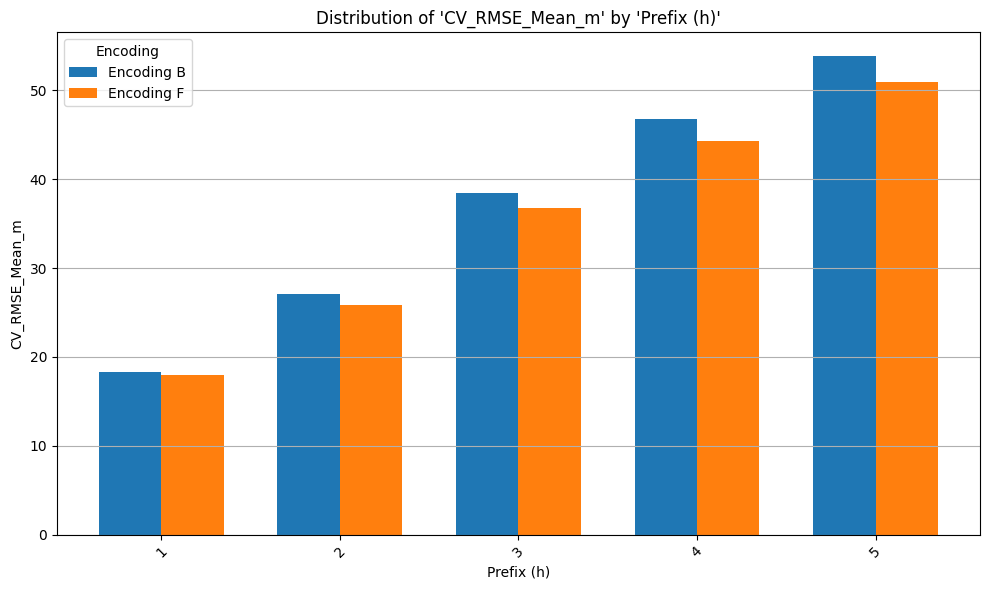

In [16]:
plot_custom_distribution_side_by_side(df_ml, "Prefix (h)", "CV_RMSE_Mean_m", "Encoding")

In [17]:
print(">> Saving ML results")

path_out = Path(ml_dir) / "ML_ensemble_results.csv"
print("File:", path_out)
df_ml.to_csv(path_out, sep=";", index=False)

path_out = Path(ml_dir) / "ML_ensemble_results.xlsx"
print("File:", path_out)
df_ml.to_excel(path_out, index=False, sheet_name="ML_ensemble_results")

>> Saving ML results
File: data_ml/ML_ensemble_results.csv
File: data_ml/ML_ensemble_results.xlsx


In [18]:
# program end
end_time = datetime.now().replace(microsecond=0)
delta_time = end_time - start_time

print("End process:", end_time)
print("Time to finish:", delta_time)

print()
print("*** PROGRAM END ***")
print()

End process: 2024-08-03 13:10:25
Time to finish: 0:04:20

*** PROGRAM END ***

